In [ ]:
import os
import zipfile
import random
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
import matplotlib.pyplot as plt
from google.colab import files
from keras.preprocessing import image
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications import ResNet50, VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.callbacks import EarlyStopping, Callback, ModelCheckpoint
import numpy as np
from keras.callbacks import Callback
from PIL import Image
import gdown
import json

In [ ]:
from google.colab import drive, files
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
path_zip = '/content/drive/MyDrive/Kumpulan Dataset/Dataset Jalan Berlubang/Jalan_Berlubang_Renaldy.zip'
zip_ref   = zipfile.ZipFile(path_zip, 'r')
zip_ref.extractall()
zip_ref.close()


In [ ]:

def convert_webp_to_jpg(folder_path):
    for filename in os.listdir(folder_path):
        if filename.endswith(".webp"):
            # Open the .webp file
            webp_file_path = os.path.join(folder_path, filename)
            im = Image.open(webp_file_path)

            # Save as .jpg
            jpg_file_path = os.path.splitext(webp_file_path)[0] + ".jpg"
            im.save(jpg_file_path, "JPEG")
            print(f"Converted {filename} to {jpg_file_path}")

            # Remove the original .webp file
            os.remove(webp_file_path)
            print(f"Removed {filename}")

# Replace 'folder_path' with the path to your folder containing the .webp files
trainval_path = "/content/Jalan_Berlubang/trainval"
convert_webp_to_jpg(f'{trainval_path}/normal')
convert_webp_to_jpg(f'{trainval_path}/potholes')

Converted penyebab-keausan-jalan-aspal-di-jalan-kota.webp to /content/Jalan_Berlubang/trainval/normal/penyebab-keausan-jalan-aspal-di-jalan-kota.jpg
Removed penyebab-keausan-jalan-aspal-di-jalan-kota.webp
Converted tol-rembang.webp to /content/Jalan_Berlubang/trainval/normal/tol-rembang.jpg
Removed tol-rembang.webp
Converted IMG-20200426-WA0132-scaled.jpg.webp to /content/Jalan_Berlubang/trainval/normal/IMG-20200426-WA0132-scaled.jpg.jpg
Removed IMG-20200426-WA0132-scaled.jpg.webp
Converted 1625300431779.webp to /content/Jalan_Berlubang/trainval/normal/1625300431779.jpg
Removed 1625300431779.webp
Converted Suhaili-Ahli-Aspal.webp to /content/Jalan_Berlubang/trainval/normal/Suhaili-Ahli-Aspal.jpg
Removed Suhaili-Ahli-Aspal.webp
Converted terowongan-nagreg.webp to /content/Jalan_Berlubang/trainval/normal/terowongan-nagreg.jpg
Removed terowongan-nagreg.webp
Converted 060152900_1679581025-20230323_184609.webp to /content/Jalan_Berlubang/trainval/normal/060152900_1679581025-20230323_184609.

In [ ]:

def filter_files(folder_path):
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        if os.path.isfile(file_path):
            # Check if the file extension is not in the specified list
            if not filename.lower().endswith(('.jpg', '.jpeg', '.png')):
                # Remove the file
                os.remove(file_path)
                print(f"Removed {filename}")

# Replace 'folder_path' with the path to your folder
filter_files(f'{trainval_path}/normal')
filter_files(f'{trainval_path}/potholes')

Removed suasana-jalan-di-kota-surabaya-hari-pertama-lebaran--thumbnail-749.txt
Removed 97.b6d690f129694c2d824c5979fca7ad33.gif


In [ ]:
def train_val_generators(TRAINING_DIR, TESTING_DIR):
  datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
  )

  train_generator = datagen.flow_from_directory(
      TRAINING_DIR,
      target_size=(224, 224),
      batch_size=32,
      class_mode='binary',
      subset='training'
  )

  validation_generator = datagen.flow_from_directory(
      TRAINING_DIR,
      target_size=(224, 224),
      batch_size=32,
      class_mode='binary',
      subset='validation'
  )
  test_datagen = ImageDataGenerator(
    rescale=1. / 255
  )
  test_generator = test_datagen.flow_from_directory(
      TESTING_DIR,
      target_size=(224, 224),
      batch_size=32,
      class_mode='binary',
      shuffle=False
  )
  return train_generator, validation_generator, test_generator

In [ ]:
train_generator, validation_generator , test_generator = train_val_generators('/content/Jalan_Berlubang/trainval', '/content/Jalan_Berlubang/test')

Found 1960 images belonging to 2 classes.
Found 489 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


In [ ]:
train_generator.image_shape

(224, 224, 3)

In [ ]:

def create_model():
  base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

  # Membekukan lapisan-lapisan pada model VGG16 yang sudah dilatih
  for layer in base_model.layers:
      layer.trainable = False

  # Menambahkan lapisan klasifikasi baru di atas model VGG16
  model = Sequential(name='Deteksi_Jalan_Berlubang_Renaldy_V3')
  model.add(base_model)
  model.add(Flatten())
  model.add(Dense(192, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))  # Lapisan output untuk klasifikasi biner

  model.compile(optimizer=Adam(lr=0.001),
                loss='binary_crossentropy',
                metrics=['accuracy'])

  return model

In [ ]:
class CustomCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
      if logs.get('val_accuracy') >= 0.95 and logs.get('val_loss') <= 0.05 and logs.get('accuracy') >= 0.95 and logs.get('loss') <= 0.05:
        print("\nAkurasi mencapai 95% dan loss kurang dari 5%")
        self.model.stop_training = True
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
custom_callback = CustomCallback()
model = create_model()
model.load_weights('/content/drive/MyDrive/Kumpulan Dataset/Dataset Jalan Berlubang/Deteksi_JalanBerlubang_Renaldy.h5')
checkpoint_callback = ModelCheckpoint(
    filepath='model_checkpoint_jalanBerlubang_Renaldy_v4.h5',
    save_weights_only=True,
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "Deteksi_Jalan_Berlubang_Renaldy_V3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 192)               4817088   
                                                                 
 dense_1 (Dense)             (None, 1)                 193       
                                                                 
Total params: 19531969 (74.51 MB)
Trainable params: 4817281 (18.38 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [ ]:
#model.load_weights('/content/drive/MyDrive/Kumpulan Dataset/Dataset Jalan Berlubang/model_checkpoint_jalanBerlubang_Renaldy_.h5')
# Train the model
# Note that this may take some time.
history = model.fit(train_generator,
                    initial_epoch = 11,
                    epochs=100,
                    validation_data=validation_generator,
                    callbacks=[early_stopping_callback,checkpoint_callback],
                    verbose = 1)

Epoch 12/100
38/62 [=================>............] - ETA: 19s - loss: 0.0516 - accuracy: 0.9786

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


62/62 [==============================] - ETA: 0s - loss: 0.0483 - accuracy: 0.9796
Epoch 12: val_loss improved from inf to 0.03662, saving model to model_checkpoint_jalanBerlubang_Renaldy_v4.h5
62/62 [==============================] - 68s 1s/step - loss: 0.0483 - accuracy: 0.9796 - val_loss: 0.0366 - val_accuracy: 0.9796
Epoch 13/100
62/62 [==============================] - ETA: 0s - loss: 0.0516 - accuracy: 0.9842
Epoch 13: val_loss improved from 0.03662 to 0.02767, saving model to model_checkpoint_jalanBerlubang_Renaldy_v4.h5
62/62 [==============================] - 62s 1s/step - loss: 0.0516 - accuracy: 0.9842 - val_loss: 0.0277 - val_accuracy: 0.9857
Epoch 14/100
62/62 [==============================] - ETA: 0s - loss: 0.0548 - accuracy: 0.9832
Epoch 14: val_loss did not improve from 0.02767
62/62 [==============================] - 65s 1s/step - loss: 0.0548 - accuracy: 0.9832 - val_loss: 0.0622 - val_accuracy: 0.9796
Epoch 15/100
62/62 [==============================] - ETA: 0s - 

In [ ]:
files.download('model_checkpoint_jalanBerlubang_Renaldy_v4.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

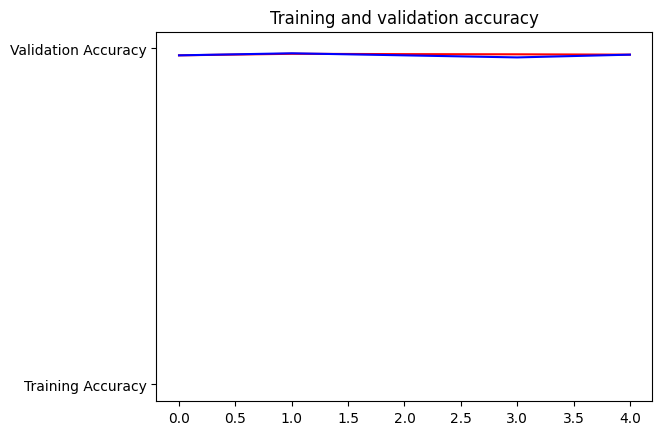

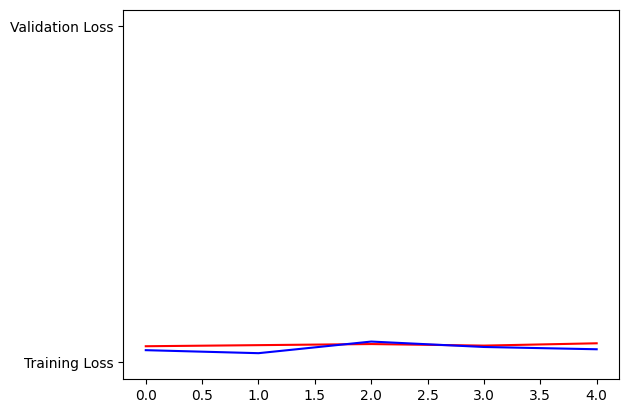

In [ ]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.show()
print("")

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.show()

In [ ]:
model.save("Deteksi_JalanBerlubang_Renaldy_V4.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:

print("SIlahkan upload gambar yang akan di prediksi")
# Upload the image file
uploaded = files.upload()

# Get the file name
file_name = list(uploaded.keys())[0]
# Load the uploaded image
img = image.load_img(file_name, target_size=(224,224))
img_array = img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

# Preprocess the image (similar to how the training data was preprocessed)
img_array = img_array / 255.0  # Normalize pixel values to be between 0 and 1

predictions = model.predict(img_array)
predicted_class = np.argmax(predictions)

SIlahkan upload gambar yang akan di prediksi


In [ ]:
hasil = 'Jalan Normal' if predictions <= 0.5 else "Jalan Berlubang/Rusak"
print(f'Hasil prediksi model =', hasil)

In [ ]:
history_json = json.dumps(history.history)

# Save as a JSON file
with open('history.json', 'w') as json_file:
    json_file.write(history_json)
files.download('history.json')  # Replace 'history.json' with your file name
files.download('Deteksi_JalanBerlubang_Renaldy_V4.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
model.evaluate(test_generator)

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
# Retrieve true labels from the validation generator
true_labels = test_generator.classes

# Generate predictions using the model and validation generator
predictions = model.predict(test_generator)

# Convert predictions to binary classes (0 or 1)
predicted_labels = np.where(predictions <= 0.5, 0, 1)

# Create the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='coolwarm', fmt='g', xticklabels=['Berlubang','Normal'], yticklabels=['Normal', 'Berlubang'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
